In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    RioCallback,
    recursive_scan,
    Para_init,
    write_excel_xlsx,
    Run_P3_model,
    Plot_Last_Single_Step,
    GetSol_dict,
    Plot_Loc_Var_2,
    Plot_Fig_1,
    Plot_Loc_Var_sol_6,
)

In [3]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[400,],
   "SaveAsList":[  [40,5,1,1,1,1],  ],
   "Ageing temperature":[25,],
   #"Particle mesh points":[120,],
   #"Exponential mesh stretch":[2.3,],
   "Para_Set":[ "Li2023_ECdrag",],
    "Model option":[
        {
            "calculate discharge energy":"true",
            "SEI":"interstitial-diffusion limited",             
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",   
            "electrolyte conductivity": "sol full"  ,
            "solvent diffusion": "double spatial consume w refill"   },
    ],
   # solvent diffusion parameters:
   #"EC transference number zero":[0.85,],
   #"Cation transference number":[0.3,],
   #"EC Lithium ion cross diffusivity [m2.s-1]":[3e-11,],
   "EC diffusivity in electrolyte [m2.s-1]":[5e-10,5e-5],

   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   #"Negative electrode diffusivity [m2.s-1]":[2e-13,],
   #"Positive electrode diffusivity [m2.s-1]":[1e-13,],
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # note!!!: Constant will overwrite Func
   "Func Electrolyte conductivity [S.m-1]":[
        "electrolyte_conductivity_Valoen2005Constant",
        ],
    "Func Electrolyte diffusivity [m2.s-1]":[
        "electrolyte_diffusivity_Valoen2005Constant",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Ratio of lithium moles to SEI moles":[2,],
   "Inner SEI reaction proportion":[0.5,],
   "Initial inner SEI thickness [m]":[2.5e-9,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[1.7e-22,],
   #'Bulk solvent concentration [mol.m-3]':[4541.0,],
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-19,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity in SEI [m2.s-1]':[1e-21,],
   'SEI kinetic rate constant [m.s-1]':[1e-12,],
   #'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 2


In [4]:
print(len(Para_dict_list))

2


In [5]:
keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Negative electrode porosity",
    "CCend Positive electrode potential [V]",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend c(EC) over c(Li+)",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",

    "CDend Negative electrode porosity",
    "CDend Positive electrode potential [V]",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend c(EC) over c(Li+)",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",

]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CC Time [h]",
    "CV Time [h]",
    "CD Terminal voltage [V]",
    "CC Terminal voltage [V]",
    "CV Terminal voltage [V]",
]
keys_cyc_AGE = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDsta Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CCsta Loss of capacity to SEI [A.h]",
    "CCend Loss of capacity to SEI [A.h]",
    "CVsta Loss of capacity to SEI [A.h]",
    "CVend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Loss of active material in positive electrode [%]",
    "CDend Loss of active material in negative electrode [%]",
    "CDend Total EC in electrolyte [mol]",
    "CDend Total EC in electrolyte and SEI [mol]",
    "CDend Total lithium in electrolyte [mol]",
    "CDend Total lithium in particles [mol]",

]
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];

In [6]:
# define experiments and scan!
V_max = 4.2;        V_min = 2.5; 
exp_AGE = [
   (f"Discharge at 1 C until {V_min} V", 
   f"Charge at 1 C until {V_max} V",  # (5 minute period)
   f"Hold at {V_max} V until C/20"),  ]# (5 minute period)
exp_AGE_2 = [
   (f"Discharge at 1 C until {V_min} V (5 seconds period)", 
   f"Charge at 1 C until {V_max} V (5 seconds period)", 
   f"Hold at {V_max} V until C/20 (5 seconds period)"),]
# step index for ageing
exp_AGE_CD = [ (
   f"Discharge at 1 C until {V_min} V (1 seconds period)",   ) ]
exp_AGE_CC = [ (
   f"Charge at 1 C until {V_max} V (1 seconds period)" ) ]
exp_AGE_CV = [ (
   f"Hold at {V_max} V until C/20 (1 seconds period)" ) ]
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

Exp_AGE_List     = [
    exp_AGE,exp_AGE,exp_AGE_2,
    exp_AGE_CD,exp_AGE_CC,exp_AGE_CV];
cycle_no = -1; 
exp_index_pack = [
   cycle_no,step_AGE_CD,
   step_AGE_CC,step_AGE_CV,];
# Path and save to excel
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R11/'; 
Target  = 'b_0_int_Dint=3e-19/' # wip\Rio_Code\P3R10\.ipynb
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'b_0_int.xlsx';sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];
# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.extend([ "exp_AGE_text", 
   "Cap Loss","LLI to SEI",
   "LAM to Neg","LAM to Pos",
   "Error"])
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, [head_list])

###########################################        
#                Scan                     #
###########################################  
Index = np.arange(1,len(Para_dict_list)+1)  
for Para_dict_i,index_i in zip(Para_dict_list,Index):
   Sol_all_i,j,midc_merge = Run_P3_model(
      index_i, Para_dict_i,   Path_pack , 
      keys_all_AGE,   Exp_AGE_List, exp_index_pack 
   )  
""" if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Run_P3_model, 
        args=(
            index_i, Para_dict_i,   Path_pack , 
            keys_all_AGE,   Exp_AGE_List, exp_index_pack 
         )   ) 
         for Para_dict_i,index_i in zip(Para_dict_list,Index)]
    result = [p.get() for p in processes] 

    """

Successfully create a excel file
Start Now! Scan 1.
Confirm: using interstitial-diffusion limited
try to run 40 cycles


In [ ]:
""" print(
    #Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries  
)
print(
    #Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries
) """
print(
    #Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[0]["X-averaged SEI interfacial current density [A.m-2]"].entries  
)
print(
    #Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[1]["X-averaged SEI interfacial current density [A.m-2]"].entries
)

[-2.97367364e-07 -4.49367645e-07 -4.97685230e-07 -5.37174564e-07
 -5.73598595e-07 -6.07923042e-07 -6.40366473e-07 -6.71007169e-07
 -6.99879458e-07 -7.26974453e-07 -7.52198978e-07 -7.75252566e-07
 -7.95313858e-07 -8.10315162e-07 -8.15616277e-07 -8.02927311e-07
 -7.62166160e-07 -6.86330567e-07 -5.75828331e-07 -4.46083564e-07
 -3.32298578e-07 -2.59970942e-07 -2.23132981e-07 -2.06285171e-07
 -1.98970582e-07 -1.95841707e-07 -1.94372425e-07 -1.93385416e-07
 -1.92306501e-07 -1.90808386e-07 -1.88640199e-07 -1.85542472e-07
 -1.81204598e-07 -1.75252496e-07 -1.67269516e-07 -1.56855677e-07
 -1.43721442e-07 -1.27802588e-07 -1.09392886e-07 -8.92935035e-08
 -6.89183593e-08 -5.01468228e-08 -3.47104957e-08 -2.34024308e-08
 -1.58650646e-08 -1.11120000e-08 -8.14061002e-09 -6.19920880e-09
 -4.78458499e-09 -3.56902269e-09 -2.37329738e-09 -1.22343051e-09
 -3.99193153e-10 -7.49708324e-11 -1.03638578e-11 -1.45525752e-12
 -1.90172307e-13 -1.36465404e-14 -2.27154886e-16 -2.30223728e-19
 -7.12838484e-21]
[-1.000

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\pybamm\util.py", line 70, in __getitem__
    return super().__getitem__(key)
KeyError: 'eta_SEI'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\GitPyBaMM\LRH_409\LRH_409\envSolCon\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rl1120\AppData\Local\Temp\ipykernel_13292\3731132339.py", line 1, in <cell line: 1>
    Plot_Loc_Var_sol(
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\wip\Rio_Code\Fun_P3\Fun_P3.py", line 289, in Plot_Loc_Var_sol
    LinesNmum = len(sol.cycles[cycle].steps[step][key].entries[0,:] )
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\pybamm\solvers\solution.py", line 537, in __getitem__
    self.update(key)
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\pybamm\solvers\solution.

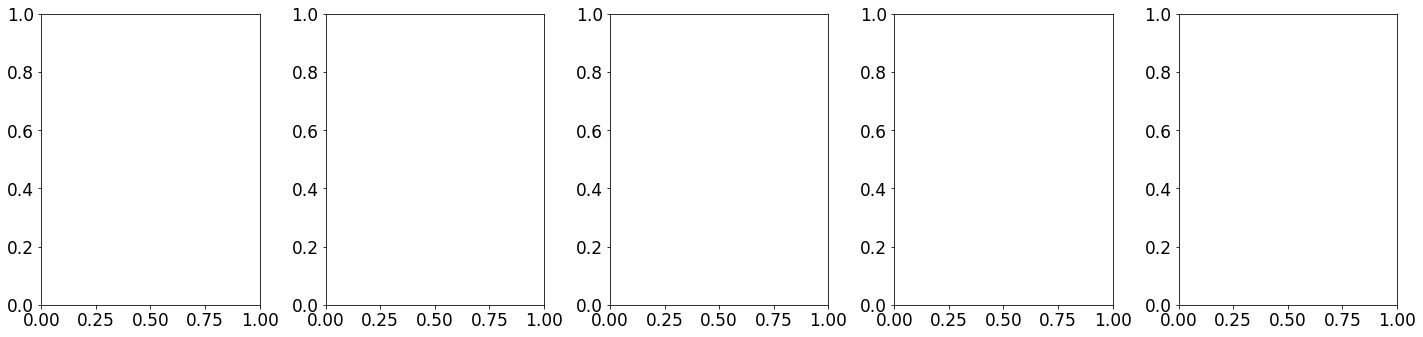

In [ ]:
Plot_Loc_Var_sol(
    Sol_all_i[0],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "eta_SEI",
        "Negative EC concentration",
        "EC surface concentration", 
        "C_sei_exp",            
        "Negative electrode SEI interfacial current density [A.m-2]",
        ],
    0,0,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_i[0],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "eta_SEI",
        "Negative EC concentration",
        "EC surface concentration",     
        "C_sei_exp",          
        "Negative electrode SEI interfacial current density [A.m-2]",
        ],
    0,1,'cool',17)

In [ ]:
Sol_all_i[0].cycles[0].steps[0]
label = ["Discharge","Charge"]
output_variables3 = [
    "EC concentration",
    "EC source term (SEI)",
    "Minus div EC flux",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_all_i[0].cycles[0].steps[0],
        Sol_all_i[0].cycles[0].steps[1],
        ], 
    output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    figsize = (12,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1.6887329920554126, step=0.01688732992055412…

In [ ]:
# Write all seperate excel files into a big file:
for i in Index:
    old_book = str(i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    #try:   # use try just in case some cases fail
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old.get_sheet_by_name(str(i))
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数

    tar_sheet_name_xlsx = 'Results';
    table_tar = data_tar.get_sheet_by_name(tar_sheet_name_xlsx)
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)

    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()
    """ except:
        print("Something goes wrong!")
    else:
        pass """

